<IPython.core.display.Javascript object>


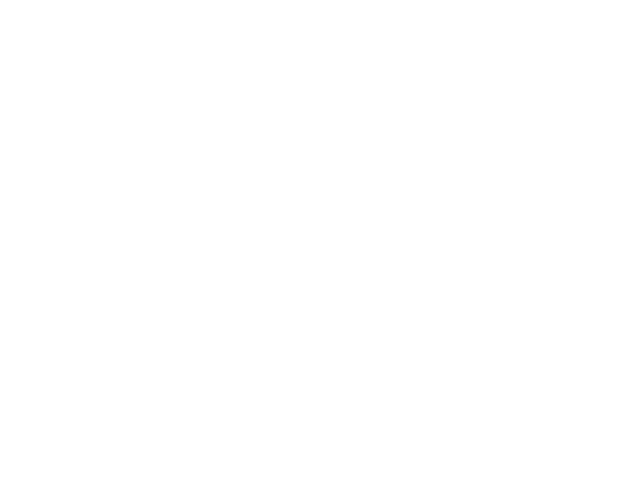

<IPython.core.display.Javascript object>


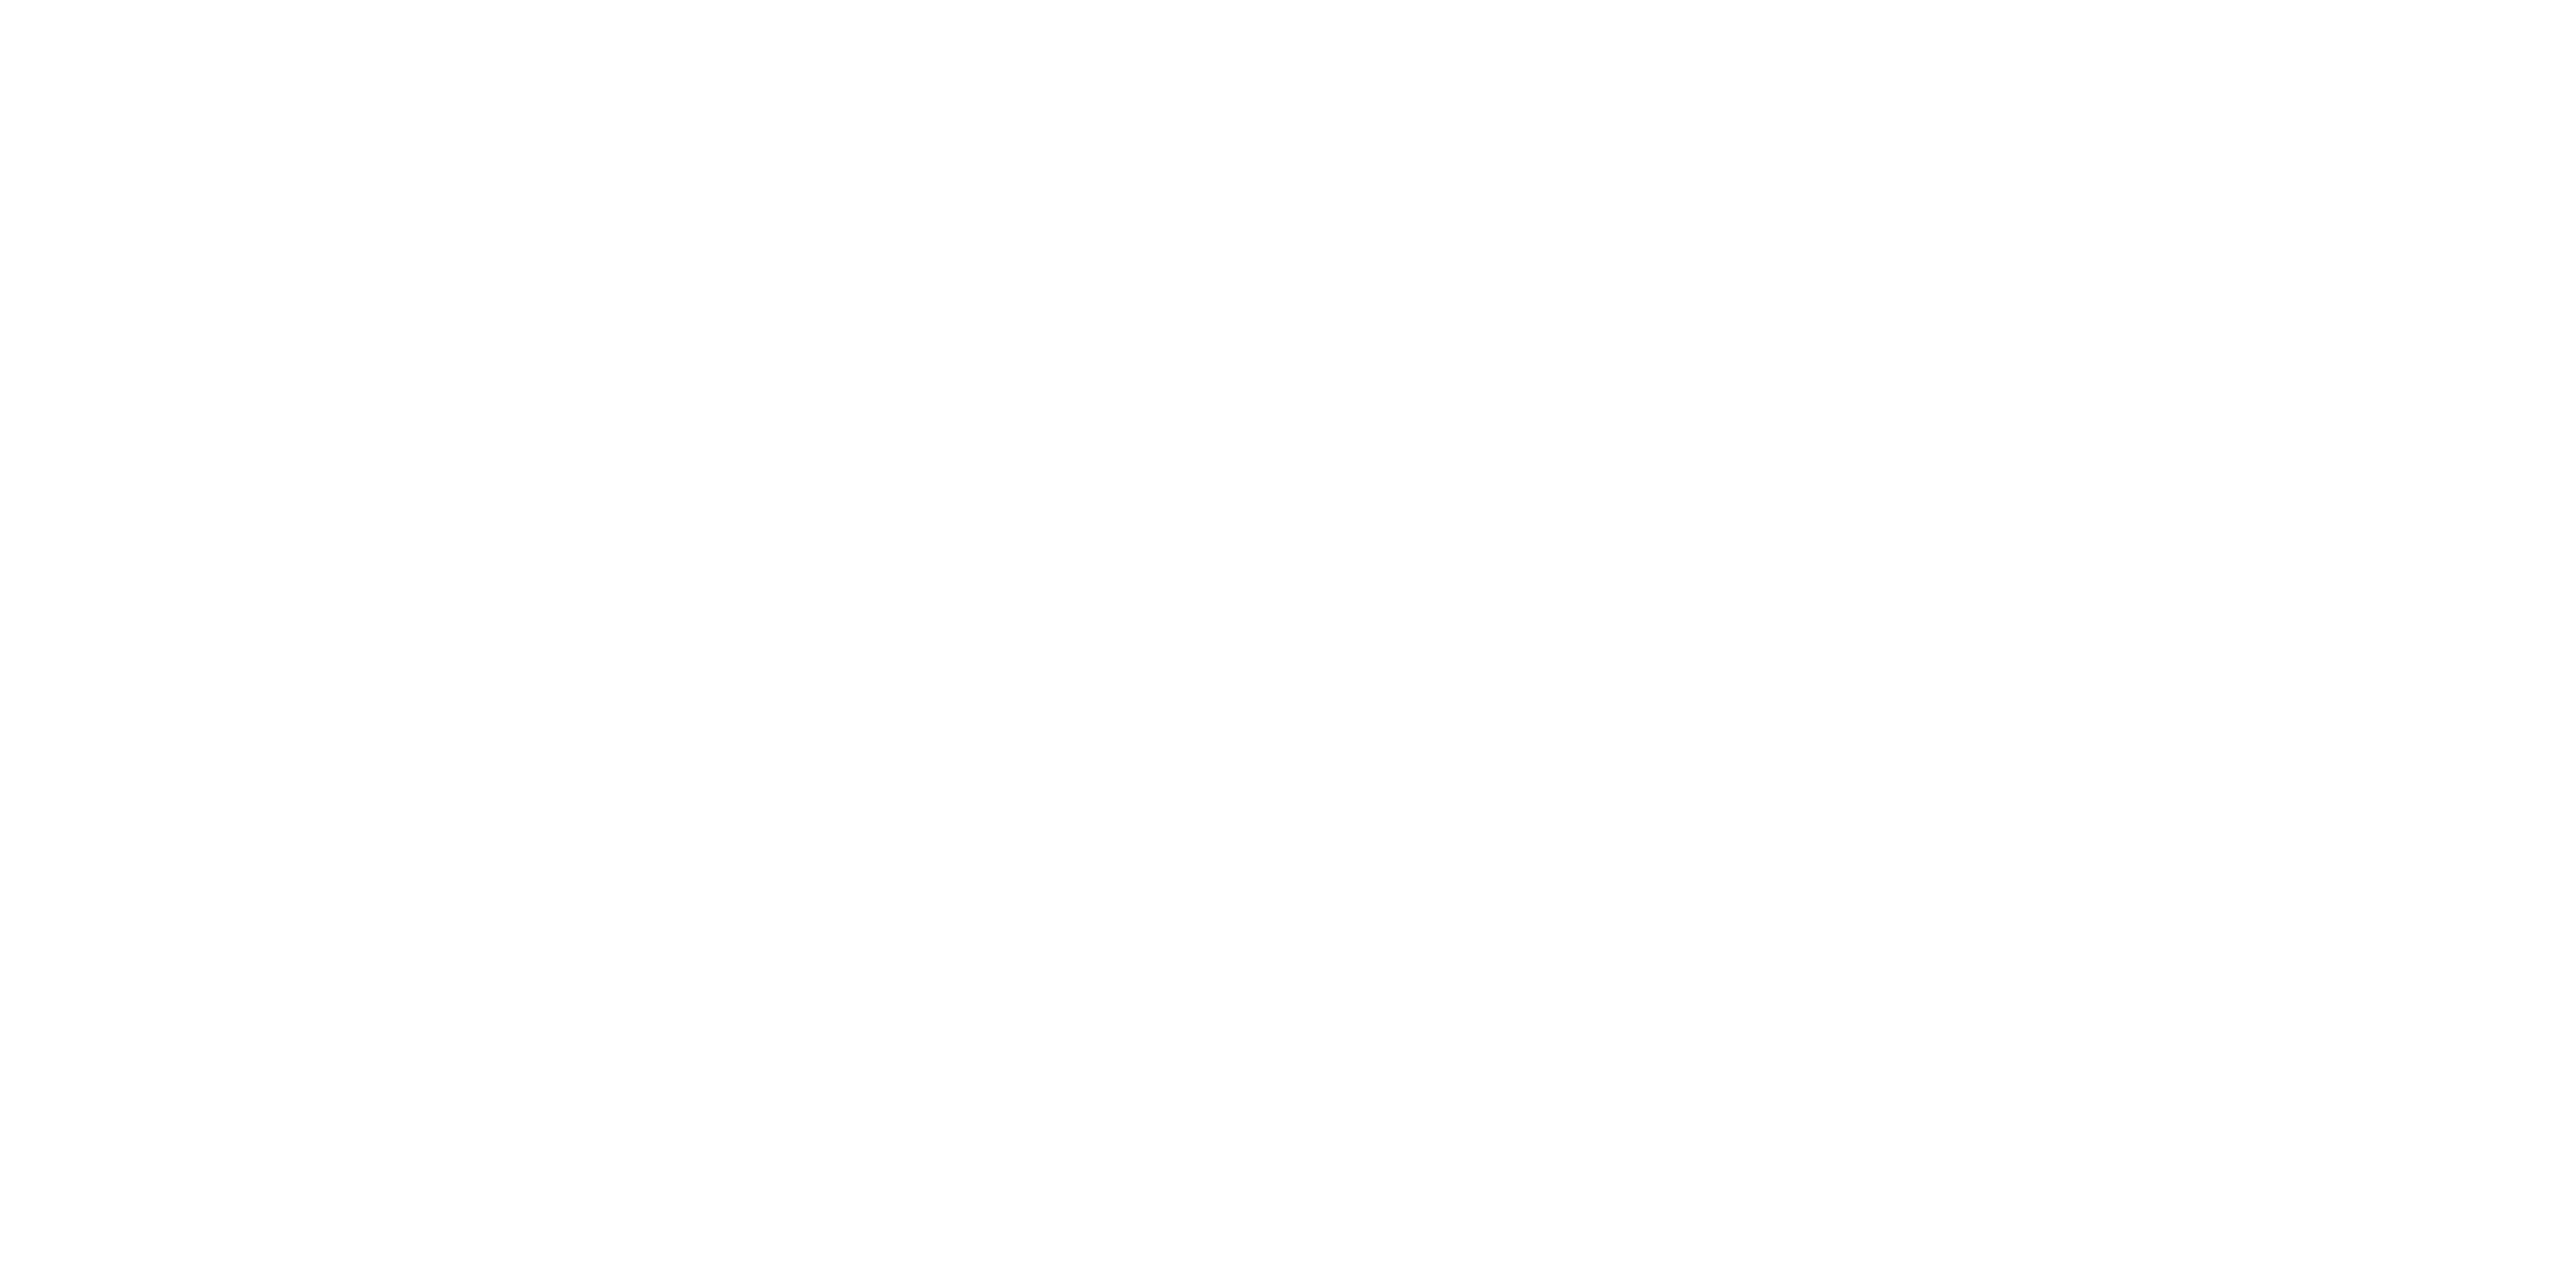

<IPython.core.display.Javascript object>


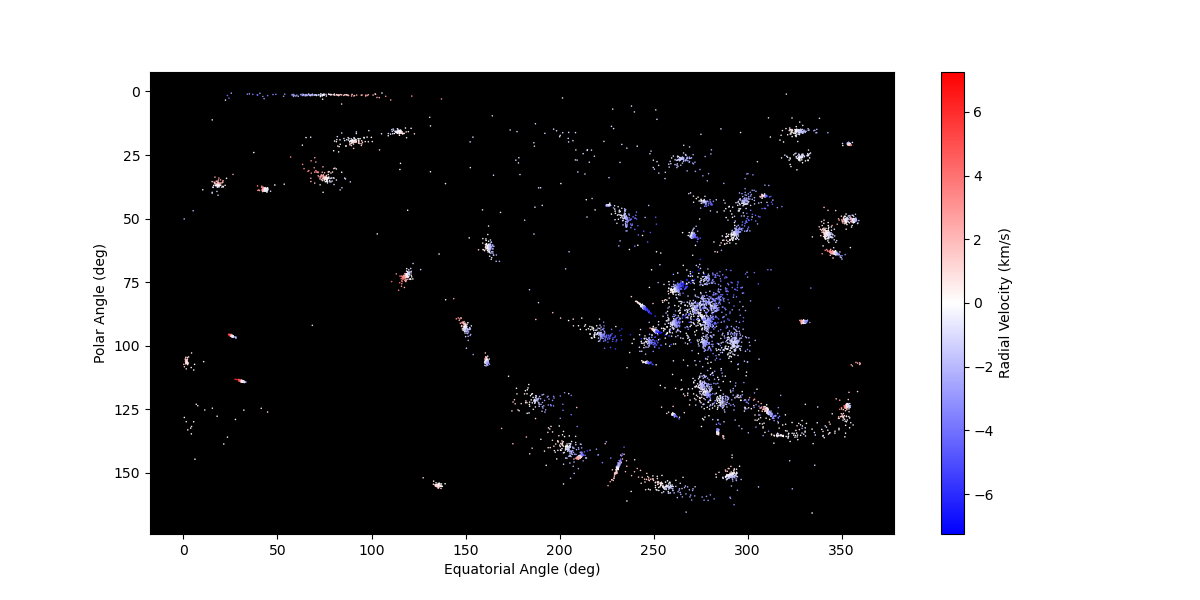

<IPython.core.display.Javascript object>


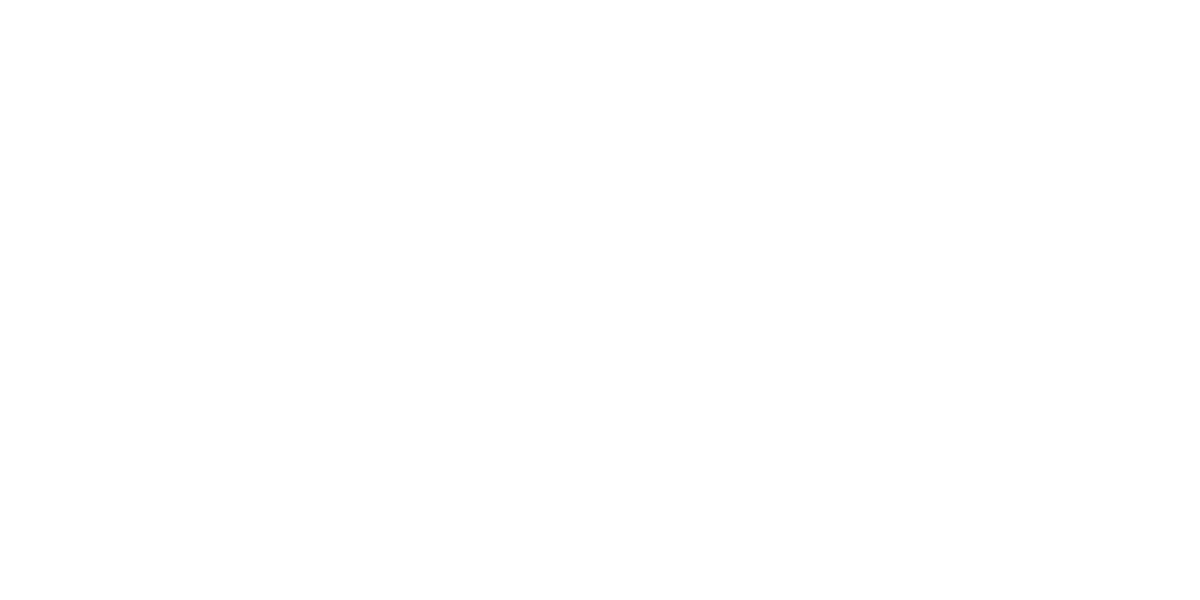

<IPython.core.display.Javascript object>


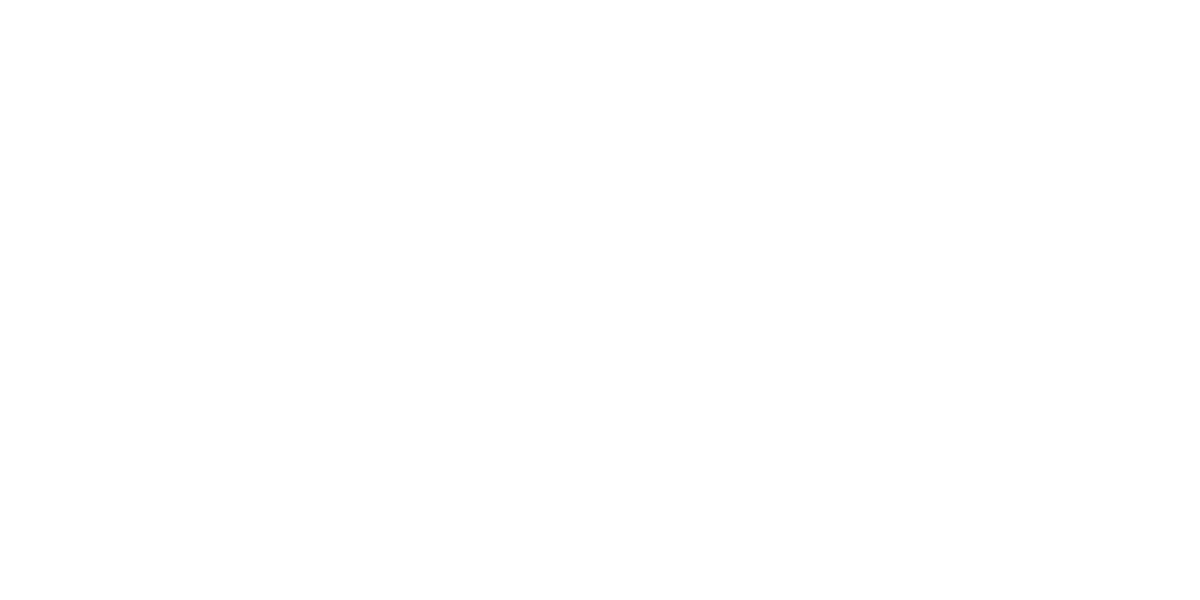

229


<IPython.core.display.Javascript object>


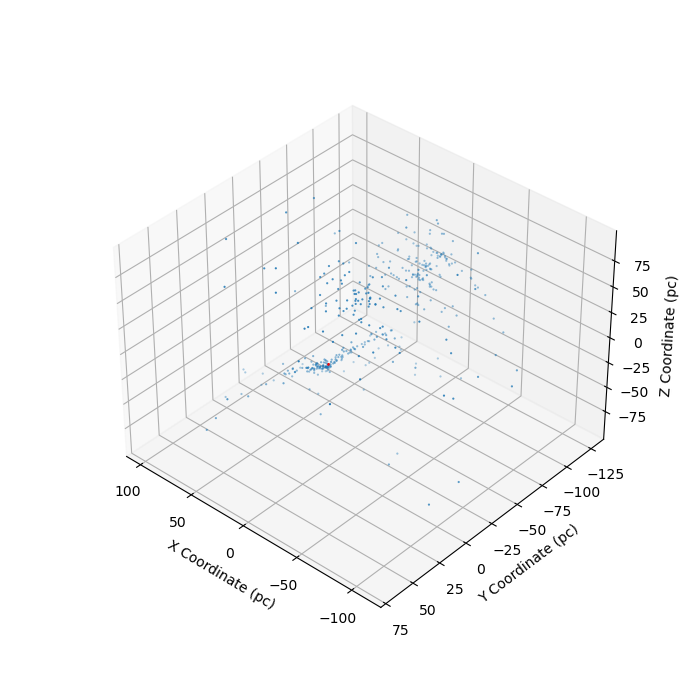

<IPython.core.display.Javascript object>


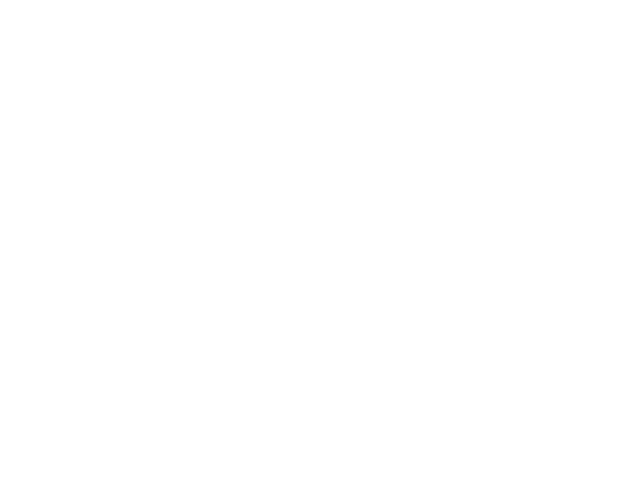

<IPython.core.display.Javascript object>


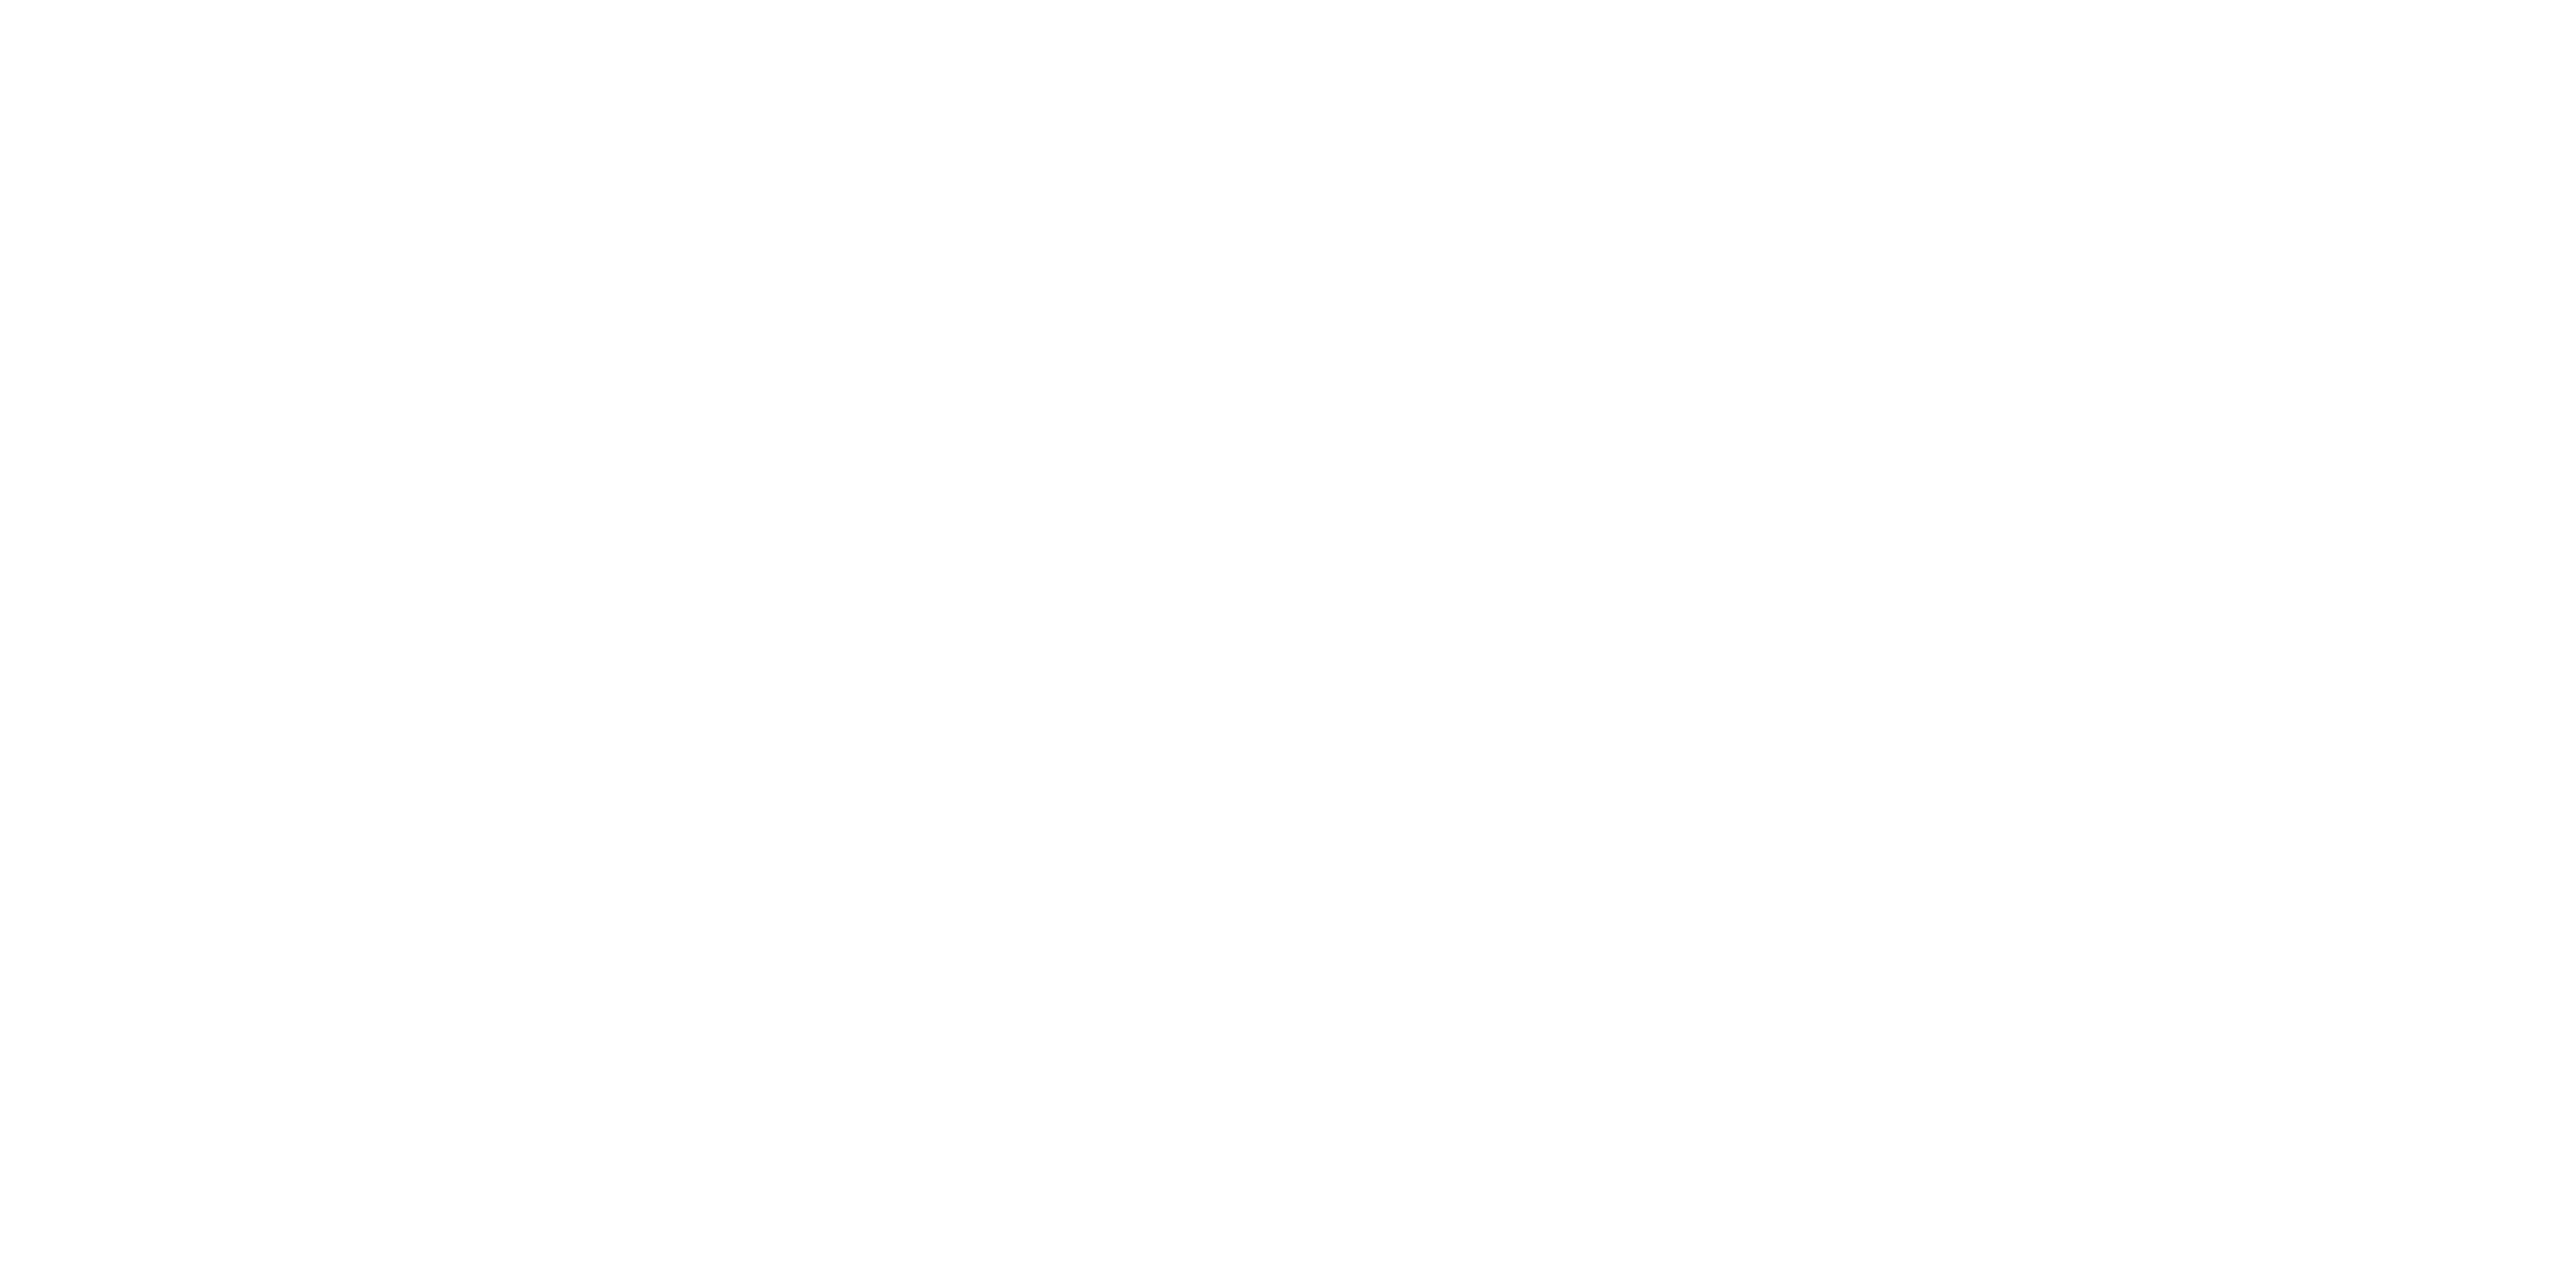

<IPython.core.display.Javascript object>


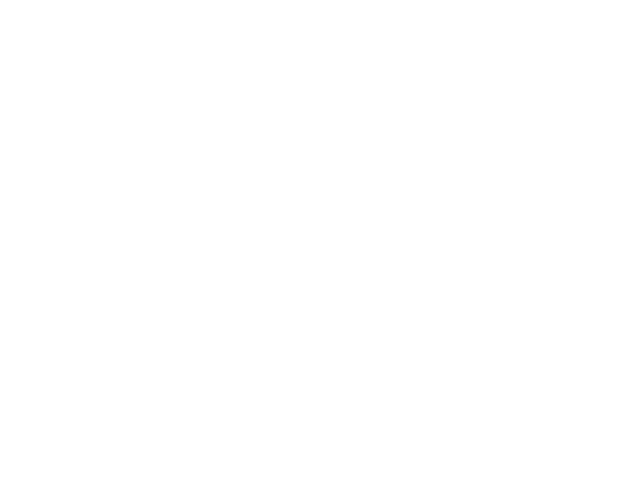

<IPython.core.display.Javascript object>


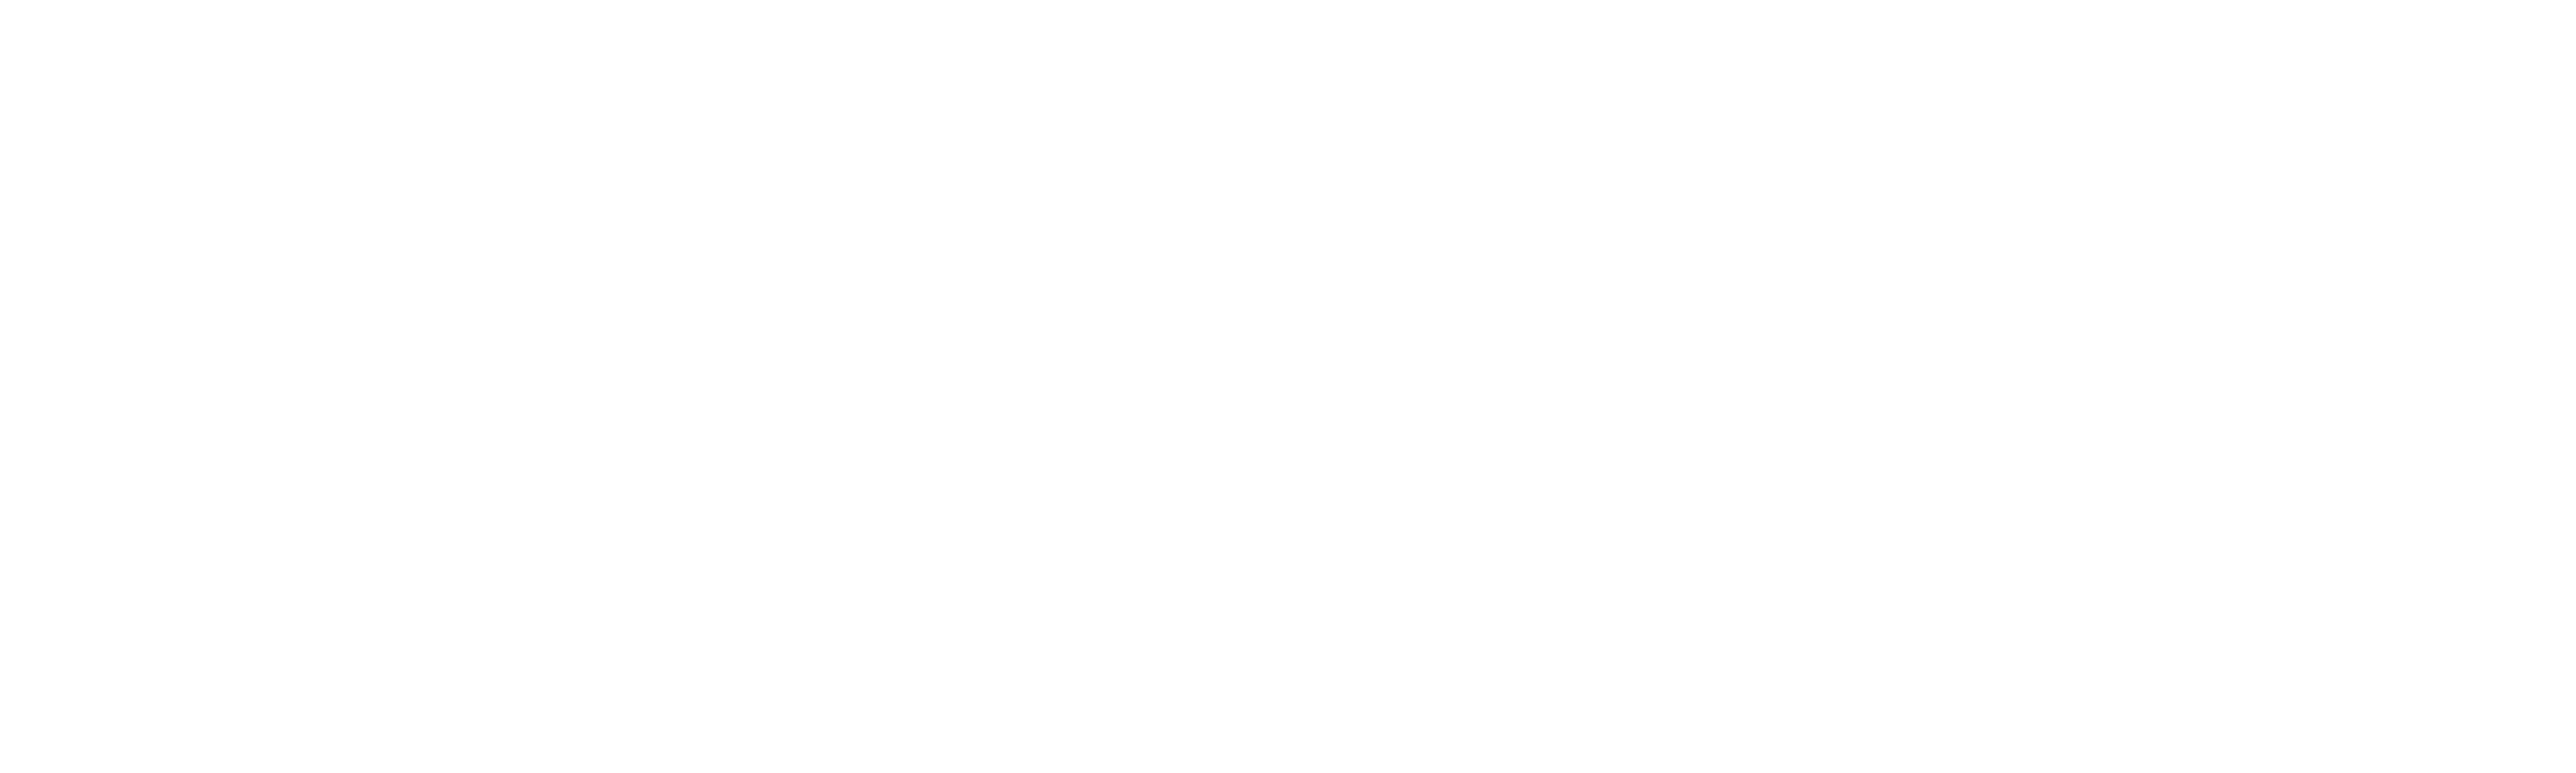

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar  1 14:43:01 2022

@author: Ryan White     s4499039

This program actually does a fair bit. In it's current state, it plots the following:
    - 'fuzzymap.png': a map of the fuzzy objects in the sky, with approximate true colour
    - 'fuzzy-redshift.png': a redshift map of the fuzzy objects in the sky
    - 'starmap.png': an approximate true colour map of the stars in the sky
    - 'star-redshift-analysis.png': a redshift star map with grids for each axis and plots of ellipses for the inferred star clusters
    - 'star-redshift-pretty.png': a redshift starmap with plot parameters such that it is aesthetically pleasing and document-friendly

To do this, it currently reads from three files which must be within the same directory as starmap.py:
    total point-like data.txt
    total fuzzy data.txt
    star clusters.txt

Since 'star clusters.txt' is only used by this file, I'll explain the required format for it here, "x y horizontal vertical theta", where:
    'x' and 'y' correspond to the (x,y) coordinates of the center of the ellipse
    'horizontal' and 'vertical' correspond to the purely x-axis and y-axis extent of the ellipse from the center
    'theta' corresponds to the angle that the semi-major axis makes relative to the positive-x-axis where the ellipse center is the origin
"""

from numpy import *
from astropy.timeseries import LombScargle
from astropy.table import Table
import os 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.ticker as plticker
import matplotlib.patches as patches
from matplotlib import animation
import pandas as pd



dir_path = os.path.dirname(os.path.realpath(__file__))  #finds the path of this program to use later
totalpoints = open(dir_path+"/total point-like data.txt", "r")       #opens and reads existing data. 
totalfuzzy = open(dir_path+"/total fuzzy data.txt", "r")
Pstardata = pd.read_csv(dir_path+"/total point-like data.txt", delimiter=' ')

clusters = pd.read_csv(dir_path+'/star clusters.txt', delimiter=' ')
cluster_xlocs = clusters['x']
cluster_ylocs = clusters['y']
cluster_x_extents = clusters['horizontal']
cluster_y_extents = clusters['vertical']
cluster_angles = clusters['theta']


stardata = totalpoints.readlines()[1:]      #assigns the data
fuzzydata = totalfuzzy.readlines()[1:]

allstaraveflux, allfuzaveflux = [], []      #initialize arrays
stararray, fuzarray = [], []
starequats, starpolar, starbright, starcolours, starredshift = [], [], [], [], []
fuzequats, fuzpolar, fuzbright, fuzcolours, fuzredshift = [], [], [], [], []

cm = plt.cm.get_cmap('bwr')     #blue to red colourmap for the redshift graphs. white is the intermediate colour
minvel = 0
maxvel = 0

for row in stardata:
    [name, equat, polar, bluef, greenf, redf, parallax, veloc, distance, period, periodunc, location] = row.split()
    bluef, greenf, redf, veloc = float(bluef), float(greenf), float(redf), float(veloc)       #cleans up variables
    rgb = [redf, greenf, bluef]
    aveflux = average(rgb)          #averages the r g b flux values
    allstaraveflux.append(aveflux)      #adds it to a list
    stararray.append([equat, polar, aveflux])       
    starequats.append(float(equat))
    starpolar.append(float(polar))         #flips the polar coords
    norm = max(rgb)         #finds max flux value for normalization purposes.
    r, g, b = 255 * redf / norm, 255 * greenf / norm, 255 * bluef / norm            #assigns the rgb values
    starcolours.append(array([r, g, b]))
    #below specifies the new min/max velocity to calibrate the redshift colourbar
    if starredshift != []:
        if veloc < min(starredshift):
            minvel = veloc
        elif veloc > max(starredshift):
            maxvel = veloc
    starredshift.append(veloc)  #adds the velocity of the current star to a redshift array for use in the graph

if maxvel < -minvel:
    maxvel = -minvel
else:
    minvel = -maxvel
    
brightest = max(allstaraveflux)         #finds the brightest star for normalization purposes

for star in stararray:
    brightness = 0.6 * abs(log10((star[2] / brightest)))           #defines scatter marker 'brightness' based on logarithmic algorithm. Spits out value between 0 and 1
    starbright.append(brightness)

starcolours = array(starcolours)/256        #gets the rgb values between 0 and 1 (because the scatter function chucked a tantrum)

#below plots the colour star map
fig, ax = plt.subplots()            #initialize axes
ax.set_xlabel('Equatorial Angle (deg)')
ax.set_ylabel('Polar Angle (deg)')
ax.set_facecolor('k')
ax.invert_yaxis()        #flips the y-axis so that polar angle is 0 at due north

starmap = plt.scatter(starequats, starpolar, s=starbright, c=starcolours, marker='.', linewidths=0)

figure(figsize=(36,18))             #units are inches
fig.savefig(dir_path+'\\starmap.png', dpi=400, bbox_inches='tight', pad_inches = 0.01)
fig.savefig(dir_path+'\\starmap.pdf', dpi=400, bbox_inches='tight', pad_inches = 0.01)

plt.close(fig)

# make 2 versions, one for analysis (blank name) and one for inclusion in report ('pretty' name)
for (scale,lwidth,name,DPI,analysis) in [(5,0,'-pretty',400,0), (0.4,0,'-analysis',600,1)]:
    #the below plots the redshift map of the stars
    fig, ax = plt.subplots(figsize=(12,6))  #units are inches
    ax.set_xlabel('Equatorial Angle (deg)')
    ax.set_ylabel('Polar Angle (deg)')
    ax.set_facecolor('k')
    ax.invert_yaxis() 
    if analysis == 1:       # version for analysis
        #the below plots major and minor gridlines according to the specified variables
        loc1 = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
        loc2 = plticker.MultipleLocator(base=5.0)
        ax.xaxis.set_minor_locator(loc1)
        ax.yaxis.set_minor_locator(loc2)
        ax.grid(which='major', axis='both', color='w', linestyle='--', linewidth=0.2)
        ax.grid(which='minor', axis='both', color='w', linestyle=':', linewidth=0.1)
        
        #the below plots existing identified star clusters on top of the image
        for cluster in range(len(clusters)):
            x = cluster_xlocs[cluster]; y = cluster_ylocs[cluster]; theta = -cluster_angles[cluster] #angle in deg, and negative due to the flipped y-axis (polar coords)
            major = 2 * cluster_x_extents[cluster] / cos(theta*pi/180)  #calculates length of major axis from the x-extent and the angle (converted to radians)
            minor = 2 * cluster_y_extents[cluster] / sin(pi/2 - theta*pi/180)   #calculates length of minor axis from the y-extent and the angle (converted to radians)
            ellipse = patches.Ellipse(xy=(x, y), width=major, height=minor, angle=theta, fill=False, edgecolor='r', linewidth=0.1)  #creates the ellipse
            ax.add_patch(ellipse)       #adds the ellipse to the image

    
    red = plt.scatter(starequats, starpolar, s=scale, c=starredshift, vmin=minvel, vmax=maxvel, cmap=cm , marker='.', linewidths=lwidth)  #note the colourmap for the redshift amount
    cbar = plt.colorbar(red)
    cbar.set_label('Radial Velocity (km/s)', rotation=90)
    fig.savefig(dir_path+f'\\star-redshift{name}.png', dpi=DPI, bbox_inches='tight', pad_inches = 0.01)
    fig.savefig(dir_path+f'\\star-redshift{name}.pdf', dpi=DPI, bbox_inches='tight', pad_inches = 0.01)

totalpoints.close()
plt.clf()           #clears the current figure in order to create the next one

fig, ax = plt.subplots(figsize=(12,6))  #units are inches
radialvelocitycutoff = 2
parallaxcutoff = 0.01
calStarEquats = Pstardata.loc[(abs(Pstardata['Parallax']) > parallaxcutoff) & (abs(Pstardata["RadialVelocity"]) < radialvelocitycutoff)].iloc[:, 1]
calStarPolar = Pstardata.loc[(abs(Pstardata['Parallax']) > parallaxcutoff) & (abs(Pstardata["RadialVelocity"]) < radialvelocitycutoff)].iloc[:, 2]
plt.scatter(calStarEquats, calStarPolar, s=2, color='w')

ax.set_xlabel('Equatorial Angle (deg)')
ax.set_ylabel('Polar Angle (deg)')
ax.set_facecolor('k')
ax.invert_yaxis() 

fig.savefig(dir_path+'\\our-galaxy.png', dpi=300, bbox_inches='tight', pad_inches = 0.01)
fig.savefig(dir_path+'\\our-galaxy.pdf', dpi=300, bbox_inches='tight', pad_inches = 0.01)

plt.close(fig)


#the following plots a 3D galaxy map
localDists = array(Pstardata.loc[(abs(Pstardata['Parallax']) > 0.007)].iloc[:, 8])
localEquat = array(Pstardata.loc[(abs(Pstardata['Parallax']) > 0.007)].iloc[:, 1])
localPolar = array(Pstardata.loc[(abs(Pstardata['Parallax']) > 0.007)].iloc[:, 2])
X = zeros(len(localDists)); Y = zeros(len(localDists)); Z = zeros(len(localDists))
for index, stardist in enumerate(localDists):
    stardist = float(stardist)
    starTheta = localEquat[index] * 2 * pi / 360
    starPhi = localPolar[index] * pi / 180
    X[index] = stardist * sin(starPhi) * cos(starTheta)
    Y[index] = stardist * sin(starPhi) * sin(starTheta)
    Z[index] = stardist * cos(starPhi)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(X, Y, Z, marker='.', s=10, linewidth=0)
ax.scatter(0, 0, 0, marker='.', s=20, c='r', linewidth=0)
ax.set_zlim(-100,100)
ax.set_zlabel("Z Coordinate (pc)")
ax.set_xlabel("X Coordinate (pc)")
ax.set_ylabel("Y Coordinate (pc)")

#the following code produces an animation of the above 3D plot, rotating the axis by 360 degrees to give a full view of the picture
frames = 200
fps = 20
def animate(i):
    ax.view_init(elev=10., azim=i * (360 / frames))
    return fig,

ani = animation.FuncAnimation(fig, animate, frames=frames, interval=round(1000/fps,0))

plt.tight_layout()
plt.show()

ani.save(dir_path + "\\3D Scatter Animation.gif", writer='pillow')

#now that the animation is done and saved, time to save the original plots
fig.savefig(dir_path+'\\3D-galaxy.png', dpi=300, bbox_inches='tight', pad_inches = 0.01)
fig.savefig(dir_path+'\\3D-galaxy.pdf', dpi=300, bbox_inches='tight', pad_inches = 0.01)

ax.view_init(10, 10)

fig.savefig(dir_path+'\\3D-galaxy-rotated.png', dpi=300, bbox_inches='tight', pad_inches = 0.01)
fig.savefig(dir_path+'\\3D-galaxy-rotated.pdf', dpi=300, bbox_inches='tight', pad_inches = 0.01)

try:
    plt.close(fig)
except UserWarning:
    plt.close(fig)




#following does fuzzy maps
minvel = 0
maxvel = 0

for row in fuzzydata:       #functionally identical to the star loop
    [name, equat, polar, bluef, greenf, redf, size, veloc, dist, location] = row.split()
    bluef, greenf, redf, veloc = float(bluef), float(greenf), float(redf), float(veloc)
    rgb = [bluef, greenf, redf]
    aveflux = average(rgb)
    allfuzaveflux.append(aveflux)
    fuzarray.append([equat, polar, aveflux])
    fuzequats.append(float(equat))
    fuzpolar.append(float(polar))         #flips the polar coords
    norm = max(rgb)         #finds max flux value for normalization purposes.
    r, g, b = 255 * redf / norm, 255 * greenf / norm, 255 * bluef / norm
    fuzcolours.append(array([r, g, b]))
    fuzredshift.append(veloc)
    if fuzredshift != []:
        if veloc < min(fuzredshift):
            minvel = veloc
    
brightest = max(allfuzaveflux)         #finds the brightest star for normalization purposes

for fuzzy in fuzarray:
    brightness = 20*sqrt(11) * log10((fuzzy[2] / brightest) + 1)            #defines scatter marker 'brightness' based on logarithmic algorithm. Spits out value between 0 and 1
    fuzbright.append(brightness)

fuzcolours = array(fuzcolours)/256        #gets the rgb values between 0 and 1


fig, ax = plt.subplots()
ax.set_xlabel('Equatorial Angle (deg)')
ax.set_ylabel('Polar Angle (deg)')
ax.set_facecolor('k')
ax.invert_yaxis()

plt.scatter(fuzequats, fuzpolar, s=fuzbright, c=fuzcolours, marker='.', linewidths=0)

figure(figsize=(36,18))             #units are inches
fig.savefig(dir_path+'\\fuzzymap.png', dpi=600, bbox_inches='tight', pad_inches = 0.01)
fig.savefig(dir_path+'\\fuzzymap.pdf', dpi=600, bbox_inches='tight', pad_inches = 0.01)

plt.close(fig)

cm = plt.cm.get_cmap('Blues_r')

fig, ax = plt.subplots()
plt.xlabel('Equatorial Angle (deg)')
plt.ylabel('Polar Angle (deg)')
ax.set_facecolor('k')
plt.gca().invert_yaxis() 

red = plt.scatter(fuzequats, fuzpolar, s=1, c=fuzredshift, vmin=-1400, vmax=0, cmap=cm , marker='.', linewidths=0)  #note the colourmap for the redshift amount
cbar = plt.colorbar(red)
cbar.set_label('Radial Velocity (km/s)', rotation=90)
plt.show()

figure(figsize=(60,18))             #units are inches
fig.savefig(dir_path+'\\fuzzy-redshift.png', dpi=600, bbox_inches='tight', pad_inches = 0.01)
fig.savefig(dir_path+'\\fuzzy-redshift.pdf', dpi=600, bbox_inches='tight', pad_inches = 0.01)

plt.close(fig)

totalfuzzy.close()

In [ ]:
i am addicted to spinning this graph!!!!!!!!!!!!!